In [105]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Orange!

In [106]:
data=pd.read_csv(r"C:\Users\SAMSUNG\Desktop\공부파일들\excel\kaggle\citrus.csv")

## 데이터확인

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [108]:
data.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


### 시각화

In [109]:
import matplotlib.pyplot as plt
import seaborn as sb

<Figure size 640x480 with 0 Axes>

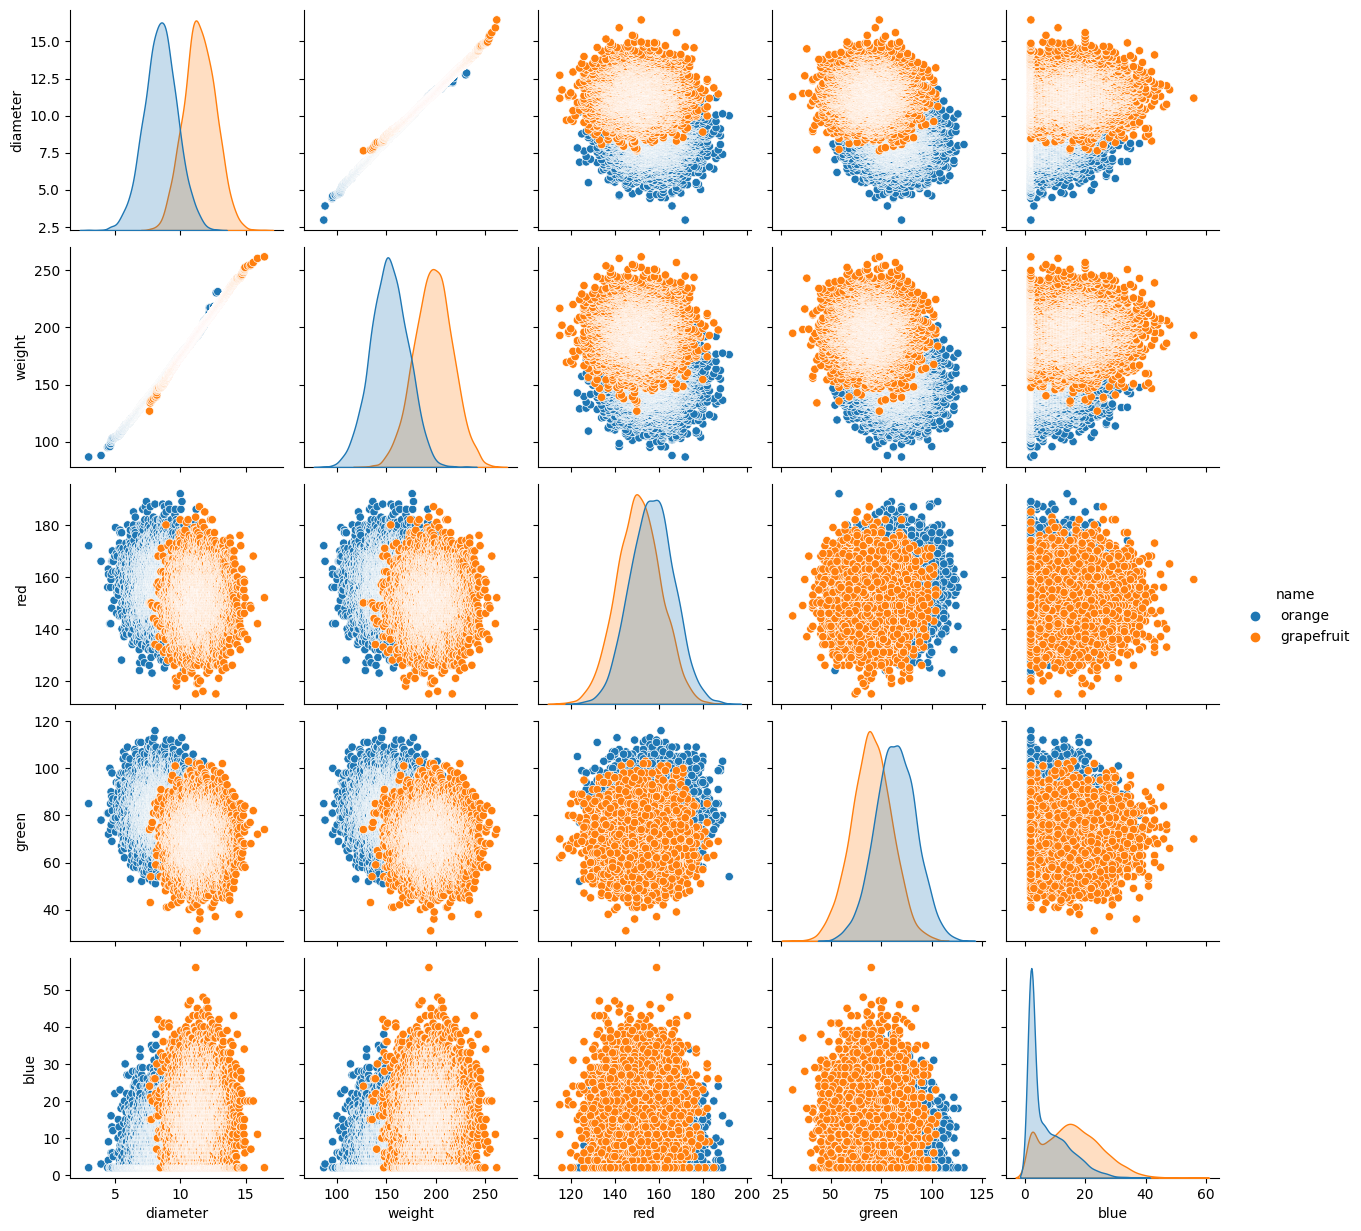

In [110]:
plt.figure()
sb.pairplot(data,hue="name")

* `Blue`의 분포가 정규성을 보이지 않음.         
그 외의 `feature`는 굉장히 좋은 데이터를 보임

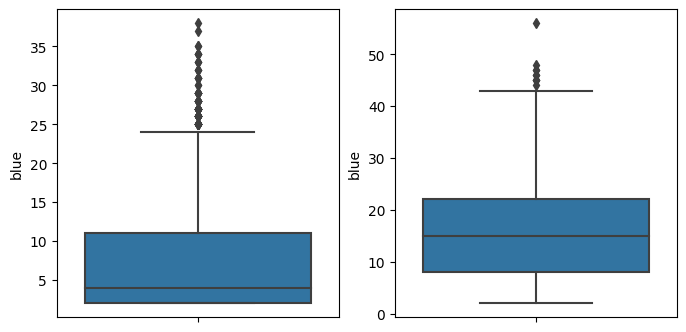

In [111]:
_,a=plt.subplots(1,2,figsize=(8,4))
sb.boxplot(data=data[data['name']=="orange"],y="blue",ax=a[0])
sb.boxplot(data=data[data['name']=="grapefruit"],y="blue",ax=a[1])
plt.show()

데이터가 오른쪽으로 긴 모양을 가짐

데이터 변환
> 주의사항 `blue`는 RGB 기반의 0~255사이의 값이였음이 훼손, 즉 해석엔 어려워질수 있음

In [112]:
data['re_blue']=data["blue"].apply(lambda x: np.log(x))

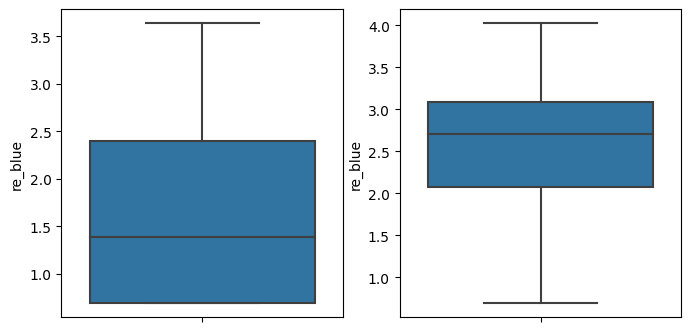

In [113]:
_,a=plt.subplots(1,2,figsize=(8,4))
sb.boxplot(data=data[data['name']=="orange"],y="re_blue",ax=a[0])
sb.boxplot(data=data[data['name']=="grapefruit"],y="re_blue",ax=a[1])
plt.show()

<Axes: xlabel='re_blue', ylabel='Count'>

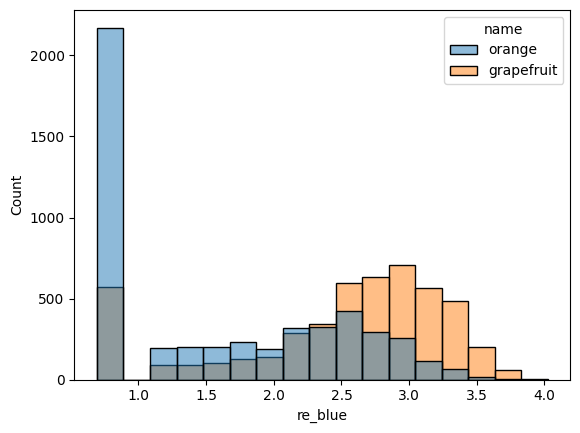

In [114]:
plt.figure()
sb.histplot(data=data,x='re_blue',hue="name")

위의 결과들을 보아, `orange`는 blue의 값의 분포가 낮은 수치에 굉장히 극단적으로 모여있음

## feature

In [115]:
target='name'
feature1=['diameter', 'weight', 'red', 'green', 'blue'] #blue값 미변환
feature2=['diameter', 'weight', 'red', 'green', 're_blue'] #blue값 변환

In [116]:
data[feature1].corr()

,diameter,weight,red,green,blue
diameter,1.000000,0.999476,-0.217821,-0.396832,0.363307
weight,0.999476,1.000000,-0.214714,-0.392003,0.358916
red,-0.217821,-0.214714,1.000000,0.148937,-0.135900
green,-0.396832,-0.392003,0.148937,1.000000,-0.242495
blue,0.363307,0.358916,-0.135900,-0.242495,1.000000


`diameter`와 `weight`간의 상관관계가 높아 보임
> 물론 현제 비선형 관계를 고려한 모델이므로 상관없어보이지만, 불필요한 계산량을 줄일 수 있다는 측면에서 차원축소를 고려하겠음

#### feature selection

In [117]:
import statsmodels.api as sm

VIF

In [118]:
while True:
    vif=[]
    for col in feature2:
        model=sm.OLS(exog=data[[x for x in feature2 if x!=col]],endog=data[col]).fit()
        vif.append({'col':col,'vif':1/(1-model.rsquared)})
    if all(map(lambda x: True if x<10 else False,[value['vif'] for value in vif])):
        break
    # 지나치게 columns이 제거되는 것을 방지
    if len(vif)<=3:
        break
    temp=[value for value in vif]
    temp.sort(key=lambda x:x['vif'])
    feature2.remove(temp[-1]['col'])

In [119]:
pd.DataFrame(vif).sort_values(by='vif',ascending=False)

,col,vif
0,diameter,17.711276
1,green,12.294735
2,re_blue,6.097461


위의 3개의 feature만을 이용해서 모델을 생성해보자

In [120]:
import sklearn.discriminant_analysis as skdis
import sklearn.model_selection as skmod
np.random.seed(10)

In [121]:
train,test=skmod.train_test_split(data[[target]+feature2],train_size=0.7,random_state=10,stratify=data[target])

QDA 모델 생성 및 학습

In [122]:
QDA=skdis.QuadraticDiscriminantAnalysis()
QDA.fit(X=train[feature2],y=train[target])

QuadraticDiscriminantAnalysis()

훈련 결과

In [125]:
QDA.score(X=train[feature2],y=train[target])

0.9245714285714286

검증 정확도

In [123]:
QDA.score(X=test[feature2],y=test[target])

0.929

결과 시각화

In [132]:
test["pred"]=QDA.predict(X=test[feature2])

컬럼 조합

In [138]:
import itertools
comb_col=list(itertools.combinations(feature2,r=2))

결과 시각화

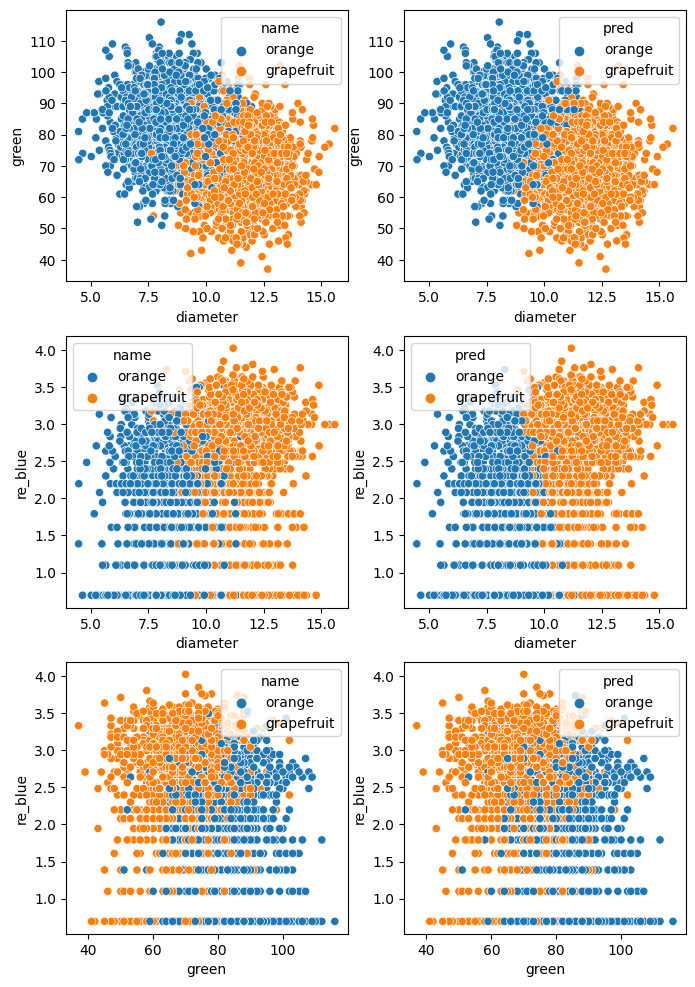

In [141]:
f,a=plt.subplots(3,2,figsize=(8,12))
for i in range(len(a)):
    sb.scatterplot(test,x=comb_col[i][0],y=comb_col[i][1],hue='name',ax=a[i][0])
    sb.scatterplot(test,x=comb_col[i][0],y=comb_col[i][1],hue='pred',ax=a[i][1])

## 만약 종속변수가 없었다면?

In [142]:
import sklearn.cluster as skclu

* 파라미터 설명

|파라미터|설명|default|
|--|--|--|
|init|초기값 설정 방법|kmeans++|
|n_init|init 실행수(즉 초기값을 여러번 selection해서 가져옴)||
|max_iter|cluster의 중심점 변경횟수|300|

In [145]:
cluster=skclu.KMeans(n_clusters=2,init="random",n_init=10,max_iter=500,random_state=10)

In [149]:
cluster.fit(data[feature1])

KMeans(init='random', max_iter=500, n_clusters=2, n_init=10, random_state=10)

In [152]:
import sklearn.metrics as skmet

In [153]:
# 이건 n의 개수를 판단하는것
# cluster.inertia_ 
skmet.silhouette_score(data[feature1],cluster.labels_)

0.4342296582659281

### 궁금함의 영역(시각화)

In [154]:
import sklearn.decomposition as skdes

In [164]:
pca=skdes.PCA(n_components=2)

In [165]:
pca.fit(X=data[feature1])

PCA(n_components=2)

In [166]:
pca.explained_variance_ratio_

array([0.75878832, 0.09926636])

In [169]:
trans_cols=pca.fit_transform(data[feature1])

In [187]:
trans_data=pd.merge(data['name'],pd.DataFrame(trans_cols),right_index=True,left_index=True)
trans_data['cluster_result']=pd.DataFrame(cluster.predict(data[feature1])).applymap(lambda x:'group1' if x!=1 else "group2")

In [188]:
trans_data.head(3)

,name,0,1,cluster_result
0,orange,90.455954,-2.099107,group1
1,orange,87.257812,-10.550601,group1
2,orange,80.099060,-10.484625,group1


시각화

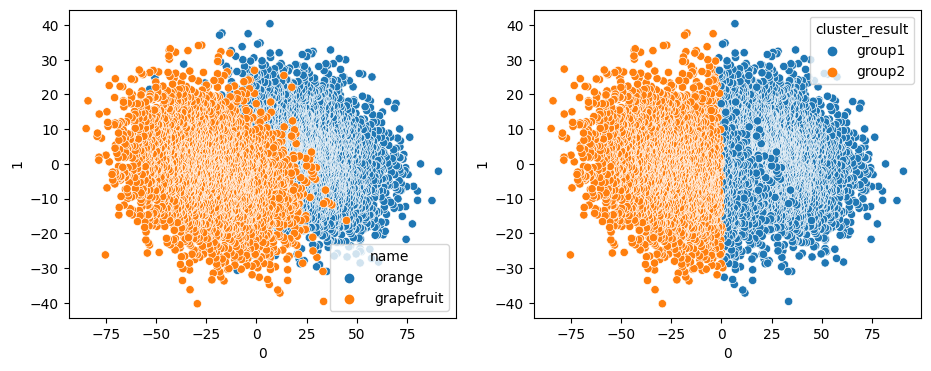

In [191]:
_,a=plt.subplots(1,2,figsize=(11,4))
sb.scatterplot(data=trans_data,x=0,y=1,hue='name',ax=a[0])
sb.scatterplot(data=trans_data,x=0,y=1,hue='cluster_result',ax=a[1])
plt.show()